<a href="https://colab.research.google.com/github/minyoungci/GAN-lab/blob/master/Season_Transfer_using_Cycle_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6a34357f9e236cdfdddba2bd39391927abafae7a5d6fc1c502a8df5f93de4eff
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!pip install kaggle_secrets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement kaggle_secrets (from versions: none)
ERROR: No matching distribution found for kaggle_secrets


In [3]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import wandb

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
path = "/content/drive/MyDrive/summer2winter-yosemite"

In [39]:
class ImageDataset(Dataset):
    
    def __init__(self,path):
        super().__init__()
        self.path = path
        self.train = os.listdir(path)
        self.image_transforms = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),])
   
    def __len__(self):
        return len(self.train)
    
    def __getitem__(self,idx):
        image = f'{self.path}/{self.train[idx]}'
        image = Image.open(image)
        if self.image_transforms:
            return self.image_transforms(image)
        return image
    

def make_dataloader(batch_size=8, **kwargs):
    dataset = ImageDataset(**kwargs)
    dataloader = DataLoader(dataset,batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=True)
    return dataloader

In [40]:
dataloader_A = make_dataloader(path=f'{path}/trainA')
dataloader_B = make_dataloader(path=f'{path}/trainB')

NotADirectoryError: ignored

In [41]:
def imshow(grid,title):
    nparray = grid.cpu().numpy()
    nparray = (nparray*0.5)+0.5
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(nparray,(1,2,0)))
    plt.show()

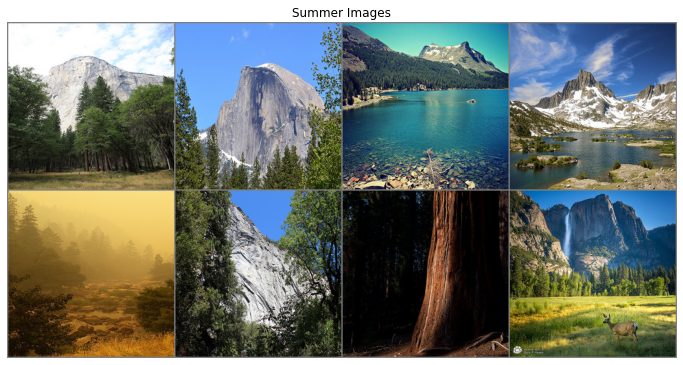

In [42]:
imgsA = next(iter(dataloader_A))
gridA = torchvision.utils.make_grid(imgsA,nrow=4)
imshow(gridA,'Summer Images')

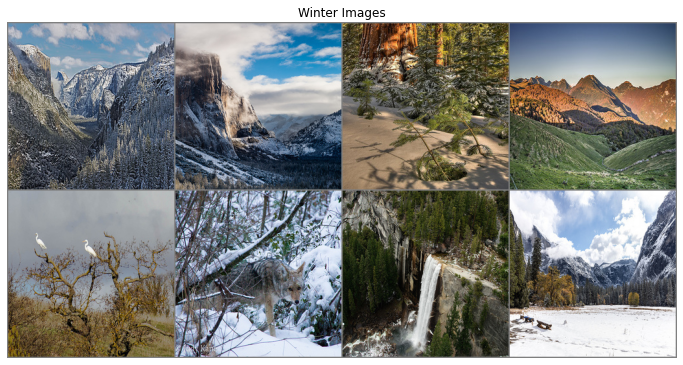

In [43]:
imgsB = next(iter(dataloader_B))
gridB = torchvision.utils.make_grid(imgsB,nrow=4)
imshow(gridB,'Winter Images')

# GAN

In [44]:
class ConvBlock(nn.Module):

  def __init__(self, in_channels, out_channels, down = True, act = True, **kwargs):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels , out_channels=out_channels , padding_mode="reflect", **kwargs)
        if down else nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, **kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace=True) if act else nn.Identity(),
    )

  def forward(self,x):
    return self.conv(x)

class ResidualBlock(nn.Module):
  
    def __init__(self,channels,**kwargs):
        super().__init__()
        self.main = nn.Sequential(
                             ConvBlock(channels,channels,kernel_size=3, padding=1),
                             ConvBlock(channels,channels,act=False,kernel_size=3, padding=1)
                                 )

    def forward(self,x):
        return x + self.main(x)

class Generator(nn.Module):

    def __init__(self,nb_features,nb_residualblock=9):
        super().__init__()
        self.first = ConvBlock(3,nb_features,kernel_size=7,stride=1,padding=3)
        self.down = nn.ModuleList(
                        [ConvBlock(nb_features,nb_features*2,kernel_size=3, stride=2, padding=1),
                        ConvBlock(nb_features*2,nb_features*4,kernel_size=3, stride=2, padding=1)]
                                 )
        self.residual_block = nn.Sequential(*[ResidualBlock(nb_features*4) for _ in range(nb_residualblock)])
        self.up = nn.ModuleList(
                        [ConvBlock(nb_features*4,nb_features*2,down=False,kernel_size=3, stride=2, padding=1, output_padding=1),
                        ConvBlock(nb_features*2,nb_features,down=False,kernel_size=3, stride=2, padding=1, output_padding=1)]
                               )
        self.last = nn.Conv2d(nb_features,3,kernel_size=7,stride=1,padding=3, padding_mode="reflect")

    def forward(self,x):
        x = self.first(x)
        for layer in self.down:
            x = layer(x)
        x = self.residual_block(x)
        for layer in self.up:
            x = layer(x)
        x = nn.Tanh()(self.last(x))
        return x


In [45]:
class Block(nn.Module):

    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.conv = nn.Sequential(
                          nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=stride,padding=1,padding_mode='reflect'),
                          nn.InstanceNorm2d(out_channels),
                          nn.LeakyReLU(0.2,inplace=True),
                             )
    def forward(self,x):
        return self.conv(x)
    

In [46]:
class Discriminator(nn.Module):

    def __init__(self,nb_features):
        super().__init__()
        self.first = nn.Sequential(
                         nn.Conv2d(3,nb_features,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
                         nn.LeakyReLU(0.2,inplace=True),
                              )
        self.convblock = nn.ModuleList(
                              [Block(nb_features,nb_features*2,2),
                               Block(nb_features*2,nb_features*4,2),
                               Block(nb_features*4,nb_features*6,1)]
                                  )
        self.last = nn.Sequential(
                        nn.Conv2d(nb_features*6,1,kernel_size=4,padding=1,padding_mode='reflect'),
                        nn.Sigmoid()
                             )
    def forward(self,x):
        x = self.first(x)
        for layer in self.convblock:    
            x = layer(x)
        x = self.last(x)
        return x

# Training class

In [47]:
class CycleGAN(nn.Module):
    
    def __init__(self,nb_features=64,lr=0.002,beta1=0.5,beta2=0.999,lambda_cycle=10.0):
        super().__init__()
        self.G_AB = torch.load("/content/drive/MyDrive/cyclegan/CycleGAN/Generator_AtoB.pth",map_location='cpu').to(device)
        self.G_BA = torch.load("/content/drive/MyDrive/cyclegan/CycleGAN/Generator_BtoA.pth",map_location='cpu').to(device)
        self.D_A  = torch.load("/content/drive/MyDrive/cyclegan/CycleGAN/Discriminator_A.pth",map_location='cpu').to(device)
        self.D_B  = torch.load("/content/drive/MyDrive/cyclegan/CycleGAN/Discriminator_B.pth",map_location='cpu').to(device)
        self.adversarial_loss = nn.MSELoss()
        self.cycle_loss = nn.L1Loss()
        self.opt_G = torch.optim.Adam(itertools.chain(self.G_AB.parameters(),self.G_BA.parameters()),lr=lr,betas=(beta1,beta2))
        self.opt_D_A  = torch.optim.Adam(self.D_A.parameters(),lr=lr,betas=(beta1,beta2))
        self.opt_D_B  = torch.optim.Adam(self.D_B.parameters(),lr=lr,betas=(beta1,beta2))
        self.lambda_cycle = lambda_cycle
    
    def setup_input(self,real_A,real_B):
        self.real_A = real_A.to(device)
        self.real_B = real_B.to(device)
        self.fake_A = self.G_BA(self.real_B)
        self.fake_B = self.G_AB(self.real_A)
    
    def optimize_D(self):
        self.D_A.train()
        self.D_B.train()
        real_preds = self.D_A(self.real_A)
        fake_preds = self.D_A(self.fake_A.detach())
        real_loss = self.adversarial_loss(real_preds,torch.ones_like(real_preds,device=device))
        fake_loss = self.adversarial_loss(fake_preds,torch.zeros_like(fake_preds,device=device))
        loss_D_A = (real_loss+fake_loss)/2
        
        real_preds = self.D_B(self.real_B)
        fake_preds = self.D_B(self.fake_B.detach())
        real_loss = self.adversarial_loss(real_preds,torch.ones_like(real_preds,device=device))
        fake_loss = self.adversarial_loss(fake_preds,torch.zeros_like(fake_preds,device=device))
        loss_D_B = (real_loss+fake_loss)/2
    
        self.opt_D_A.zero_grad()
        loss_D_A.backward()
        self.opt_D_A.step()
        
        self.opt_D_B.zero_grad()
        loss_D_B.backward()
        self.opt_D_B.step()
        
        return loss_D_A,loss_D_B
        
    def optimize_G(self):
        self.G_AB.train()
        self.G_BA.train()
        fake_preds_A = self.D_A(self.fake_A)
        fake_preds_B = self.D_B(self.fake_B)
        adversarial_loss_G_AB = self.adversarial_loss(fake_preds_B,torch.ones_like(fake_preds_B,device=device))
        adversarial_loss_G_BA = self.adversarial_loss(fake_preds_A,torch.ones_like(fake_preds_A,device=device))
        adversarial_loss_G = (adversarial_loss_G_AB + adversarial_loss_G_BA)/2
        
        cycle_loss_G_AB = self.cycle_loss(self.real_A,self.G_BA(self.fake_B))
        cycle_loss_G_BA = self.cycle_loss(self.real_B,self.G_AB(self.fake_A))
        cycle_loss_G = (cycle_loss_G_AB + cycle_loss_G_BA)/2
        loss_G = adversarial_loss_G + (self.lambda_cycle*cycle_loss_G)
    
        self.opt_G.zero_grad()
        loss_G.backward()
        self.opt_G.step()
        
        return loss_G

# Training

In [48]:
gan = CycleGAN()

In [52]:
import wandb

!wandb login

Traceback (most recent call last):
  File "/usr/local/bin/wandb", line 8, in <module>
    sys.exit(cli())
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.8/dist-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/wandb/cli/cli.py", line 102, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/wandb/cli/cli.py", line 241, in login
    wandb.setup(settings=login_settings)
  File "/usr/local/

In [53]:
wandb.init(project='CycleGAN', entity='balaji_ai',
           config=dict(nb_features=64,
                       lr=0.002,
                       beta1=0.5,
                       beta2=0.999,
                       lambda_cycle=10.0))

for iteration in range(17_000):
    real_A = next(iter(dataloader_A))
    real_B = next(iter(dataloader_B))
    gan.setup_input(real_A,real_B)
    loss_D_A,loss_D_B = gan.optimize_D()
    loss_G = gan.optimize_G()
    wandb.log({"loss_G":loss_G,"loss_D_A": loss_D_A,"loss_D_B":loss_D_B})
    if ((iteration+1)%1_000==0):
        wandb.log({"Generated Summer images" : [wandb.Image(im) for im in gan.fake_A]})
        wandb.log({"Generated Winter images" : [wandb.Image(im) for im in gan.fake_B]})

Problem at: <ipython-input-53-9953d6452fda> 1 <module>


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 1133, in init
    run = wi.init()
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_init.py", line 593, in init
    manager._inform_init(settings=self.settings, run_id=self.settings.run_id)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/wandb_manager.py", line 174, in _inform_init
    svc_iface._svc_inform_init(settings=settings, run_id=run_id)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/service/service_sock.py", line 38, in _svc_inform_init
    self._sock_client.send(inform_init=inform_init)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/lib/sock_client.py", line 211, in send
    self.send_server_request(server_req)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/lib/sock_client.py", line 155, in send_server_request
    self._send_message(msg)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/lib/sock_client.py",

Exception: ignored